# Looking at 'eli5' package explanation of classifier

#### Dependencies

In [1]:
import pandas as pd
import eli5
import matplotlib.pyplot as plit
%matplotlib inline
from eli5.sklearn import InvertableHashingVectorizer
import numpy as np


from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import TruncatedSVD

from xgboost import XGBClassifier

import sys
sys.path.append('../src')

%load_ext autoreload
%autoreload 1

from datatasks.sample_data import sample_data
%aimport datatasks.sample_data

from models.models import evaluate_model

from models.plot import plot_confusion_matrix

from models.pipeline import make_features_pipeline

/Users/jmill/anaconda3/envs/SemEval2019-4/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


#### Load data

In [2]:
DATA_PATH = '../data/'
DATA_INTERIM_PATH = DATA_PATH + 'interim/'
train = pd.read_csv(DATA_INTERIM_PATH + 'train_p.csv')
val = pd.read_csv(DATA_INTERIM_PATH + 'val_p.csv')

In [3]:
train = train[~(train['domain']=='foxbusiness')]

#### Sample data

In [4]:
train_s = sample_data(train, 70000, 'train')
val_s = sample_data(val, 10000, 'val')

In [5]:
train_s.loc[train_s["HP_links_count"] > 0, "HP_links_count"] = 1
val_s.loc[val_s["HP_links_count"] > 0, "HP_links_count"] = 1

In [6]:
y_train = train_s['hyperpartisan']
y_test = val_s['hyperpartisan']

In [7]:
my_stop_words = text.ENGLISH_STOP_WORDS.union(["jan", 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec',
                                               'january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september',
                                               'october', 'november', 'december', 'monday', 'tuesday', 'wednesday', 'thursday',
                                               'friday', 'saturday', 'sunday', 'mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun',
                                              'advertisement', 'said', 'image', 'year'
                                              '2017', '2018', '2016', '2015'])

In [22]:
vec = HashingVectorizer(norm='l2', ngram_range=(1,3), stop_words=my_stop_words)
clf = SGDClassifier()
feats = make_features_pipeline(vec, 'preprocessed_text')

pipeline = Pipeline([
    ('vec', vec),
    #('feats', feats),
    ('clf', clf)
])

In [24]:
pipeline.fit(train_s['preprocessed_text'], y_train)

/Users/jmill/anaconda3/envs/SemEval2019-4/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Pipeline(memory=None,
     steps=[('vec', HashingVectorizer(alternate_sign=True, analyzer='word', binary=False,
         decode_error='strict', dtype=<class 'numpy.float64'>,
         encoding='utf-8', input='content', lowercase=True,
         n_features=1048576, ngram_range=(1, 3), non_negative=False,
         norm='l2', pre...='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False))])

In [25]:
predicted = pipeline.predict(val_s['preprocessed_text'])
evaluate_model(predicted, y_test)

             precision    recall  f1-score   support

      False       0.72      0.52      0.61      4999
       True       0.63      0.80      0.70      5000

avg / total       0.67      0.66      0.65      9999

Accuracy: 0.6612


0.6611661166116611

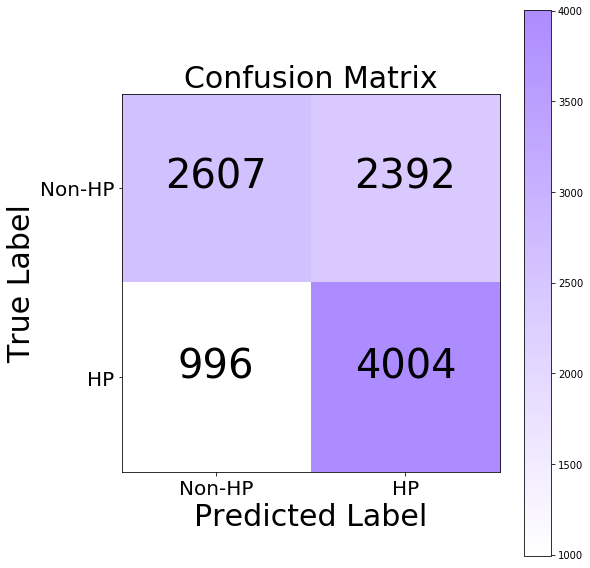

In [26]:
plot_confusion_matrix(y_test, predicted)

In [27]:
ivec = InvertableHashingVectorizer(vec)
sample_size = len(train_s['preprocessed_text']) // 10
X_sample = np.random.choice(train_s['preprocessed_text'], size=sample_size)
ivec.fit(X_sample);

In [29]:
eli5.show_weights(clf, vec=ivec, top=100)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/jmill/anaconda3/envs/SemEval2019-4/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-29-aedf53e86a81>", line 1, in <module>
    eli5.show_weights(clf, vec=ivec, top=100)
  File "/Users/jmill/anaconda3/envs/SemEval2019-4/lib/python3.6/site-packages/eli5/ipython.py", line 119, in show_weights
    expl = explain_weights(estimator, **explain_kwargs)
  File "/Users/jmill/anaconda3/envs/SemEval2019-4/lib/python3.6/site-packages/singledispatch.py", line 210, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/Users/jmill/anaconda3/envs/SemEval2019-4/lib/python3.6/site-packages/eli5/sklearn/explain_weights.py", line 217, in explain_linear_classifier_weights
    coef_scale)
  File "/Users/jmill/anaconda3/envs/SemEval2019-4/lib/python3.6/site-packages/eli5/sklearn/unhashing.py", line 255, in handle_hashing_vec
    f

KeyboardInterrupt: 

In [ ]:
obs = 799
eli5.show_prediction(clf, val_s['preprocessed_text'][obs], vec=ivec)

In [20]:
train_s.groupby('hyperpartisan')['HP_links_count'].mean()

hyperpartisan
False    0.061917
True     0.237082
Name: HP_links_count, dtype: float64